# Optimisation : Placer la plus grande maison possible dans un terrain

- La maison est un rectangle
- Le terrain est un polygone quelconque, il peut être convexe ou concave
- L'optimisation peut être faite en utilisant les algorithmes PSO, DE ou ABC

In [1]:
from sympy.geometry import Point
from sympy.geometry import Polygon as SympyPolygon
from scipy import *
from math import *
import sys
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import Polygon
import pyclipper
import functools

from IPython.display import Markdown, display, HTML
def printmd(string):
    display(Markdown(string))

## Class and converting functions

In [2]:
class Rectangle:
    """Minimal representation of a rectangle"""
    def __init__(self, point1_x, point1_y, point2_x, point2_y, longueur):
        self.point1_x = point1_x
        self.point1_y = point1_y
        self.point2_x = point2_x
        self.point2_y = point2_y
        self.longueur = longueur
        
    def side_length(self):
        return dist((self.point1_x, self.point1_y), (self.point2_x, self.point2_y))
    
    def area(self):
        return abs(self.side_length() * self.longueur)
    
    def to_rect(self, strategy="Default"):
        """Convert a minimal rectangle to a full rectangle"""
        vect = (self.point2_x - self.point1_x, self.point2_y - self.point1_y)
        distance = self.side_length()
        vectUnitaire = (vect[0] / distance * self.longueur, vect[1] / distance * self.longueur)
        normalVect = (-vectUnitaire[1], vectUnitaire[0])
        point1 = (self.point1_x, self.point1_y)
        point2 = (self.point2_x, self.point2_y)
        point3 = (self.point2_x + normalVect[0], self.point2_y + normalVect[1])
        point4 = (self.point1_x + normalVect[0], self.point1_y + normalVect[1])
        if strategy == "Default":
            return [point1, point2, point3, point4]
        else:
            return SimpyPolygon(point1, point2, point3, point4)
      
    def is_valid(self, polygon, verbose=False):
        """ Determine if the rectangle is in the polygon

        @param polygon: whether a polygon or a list of vertices
        """
        if verbose:
            print("entrée: est_valide")
            start_time = time.time()
        try:
            rectangle = self.to_rect()
            pc = pyclipper.Pyclipper()
            pc.AddPath(polygon, pyclipper.PT_CLIP, True)
            pc.AddPath(rectangle, pyclipper.PT_SUBJECT, True)

            intersections = pc.Execute(pyclipper.CT_INTERSECTION, pyclipper.PFT_EVENODD, pyclipper.PFT_EVENODD)

            res = (intersections != []) and (len(intersections[0]) == len(rectangle)) and np.all([vertice_in_polygon(v, intersections[0]) for v in rectangle]) 
            if verbose:
                print("--- %s seconds ---" % (time.time() - start_time))
            return res
        except pyclipper.ClipperException:
            if verbose:
                print("Clipper exception")
            return False

### Util functions

In [3]:
def vertice_in_polygon(vertice, polygon):
    """ Determine if the vertice is in the polygon
    Not a strict check because of the pyclipper library in which
    the coordinates are floored.
    """
    x, y = vertice
    x, y = int(x), int(y)
    return [x,y] in polygon

## Drawing functions

In [4]:
COLORS_LEGEND_MAP = {"Swarm": "purple", "Best": "blue", "Best final": "blue", "Land": "green"}
def get_color(legend):
    return COLORS_LEGEND_MAP[legend.split(" - ")[-1]]

def draw_polygon(polygon, ax=None, color="green"):
    """Draw a polygon over an axis (not shown directly)
    
    @param polygon: Whether a polygon or a path
    """
    if ax is None:
        ax = plt.gca()
    if type(polygon) == SympyPolygon:
        polygon = np.array(list(map(lambda p: [p.x, p.y], polygon.vertices)))
    p = Polygon(polygon, closed=False, color=color, alpha=0.3, lw=0)
    ax.add_patch(p)
    ax.axis('equal')
    return ax

def draw_polygons(polygons, colors=None, verbose=False):
    """Draw polygons and print the figure
    
    @param polygons: SimpyPolygon or list(SympyPolygon)
    @param colors: colors to match to the polygons
    """
    ax = plt.gca()
    if type(polygons) == SympyPolygon:
        polygons = [polygons]
    if colors is None:
        colors = ["grey"]*len(polygons)
    if len(colors) > 0 and len(colors) < len(polygons):
        colors = colors + [colors[-1]] * (len(polygons) - len(colors))
    colors.reverse()
    
    colors = deepcopy(colors)
    for polygon in polygons:
        color = colors.pop()
        if verbose:
            print(color, "Polygon : ", polygon)
        ax = draw_polygon(polygon, ax, color=color)
    return ax

In [5]:
def create_animation(legend, land):
    fig, ax = plt.subplots()
    
    ax = draw_polygons([land], colors=[get_color("Land")])
    log_frames = LOGS[legend]
    n_frames = len(log_frames)
    
    def update(i):
        log_frame = log_frames[i]

        sols = log_frame['polygons']
        polygons = [Rectangle(*sol).to_rect() for sol in sols]
        ax.clear()
        draw_polygons([land]+polygons, colors=[get_color("Land"), get_color(legend)])
        ax.set_title(log_frame['title'])
        return fig,

    anim = animation.FuncAnimation(fig, update, frames=n_frames, blit=True)
    anim = HTML(anim.to_html5_video())
    plt.close()
    return anim

## Lambda functions to use in the calls

### Logger function

In [6]:
LOGS = {}
    
def log_polygons(land, sols, colors=["green", "brown"], legend="Best", text="", padding=1, iteration=0, fitness=None, beautify=True, show=True):
    if (iteration % padding == 0):
        if not legend in LOGS.keys():
            LOGS[legend] = []
        sols = list(sols) if type(sols) == map else [sols]
        title = "Itération " + str(iteration)
        title += " : " + legend if legend is not None else ""
        title += " = " + text if text is not None else ""
        polygons = [land]+[Rectangle(*sol).to_rect() for sol in sols]
        
        if show:
            ax = plt.gca()
            ax = draw_polygons(polygons, colors)
            if beautify:
                printmd("### "+ title)
            else:
                ax.set_title(title)
            plt.show()
            
        log_to_append = {"polygons": sols, "title": title, "iteration": iteration}
        if legend.startswith("Best"):
            log_to_append['fitness'] = fitness
        LOGS[legend].append(log_to_append)

### Bounding function

In [7]:
def polygon_bounding(sol, land_polygon, verbose=False):
    if verbose:
        print("entrée: polygon_bornage")
    solution = Rectangle(*sol)
    if solution.is_valid(land_polygon):
        if verbose:
            print(sol)
            printmd("## Est valide")
        return sol 
    else:
        if verbose:
            print("this one is invalid")
        # print(sol)
        raise ValueError("Solution invalide par contrainte de bornage")

## Initialization function

In [8]:
from sympy import Symbol
def pick_random_sol(land, size=1, delta=0.05, stochastic=False, strategy="random", inf=0, sup=200):
    if strategy == "random":
        sols = []
        for _ in range(size):
            sol = random.uniform(inf,sup,5)
            rect = Rectangle(*sol)
            while not rect.is_valid(land):
                sol = random.uniform(inf,sup,5)
                rect = Rectangle(*sol)
            sols.append(sol)
        return sols
    else:
        t = Symbol('t', real=True)
        p = SympyPolygon(*land).arbitrary_point('t')
        if stochastic:
            picks = sorted([random.rand() for i in range(size*2)])
        else:
            picks = np.linspace(0, 1, size*2+1)
        points_on_perimeter = [p.subs(t, pick) for pick in picks]
        sols = [[points_on_perimeter[i*2].x, points_on_perimeter[i*2].y, points_on_perimeter[i*2+1].x, points_on_perimeter[i*2+1].y, -10-delta*2000*random.rand()] for i in range(size)]
        for sol in sols:
            while not Rectangle(*sol).is_valid(land):
                sol[4] = sol[4] / 2
        return sols

def get_border_search_field(polygon):
    min_func = lambda acc, vertice: min(min(*vertice),acc)
    max_func = lambda acc, vertice: max(max(*vertice),acc)
    
    min_search_field = functools.reduce(min_func, polygon, sys.maxsize)
    max_search_field = functools.reduce(max_func, polygon, -sys.maxsize)
    
    return min_search_field, max_search_field

# Main

In [9]:
poly1 = [(0,0), (0,100), (100,100), (110, 50), (100, 0)]
poly2 = [(0,0), (0,100), (30,90), (30,40), (71,25), (71,100), (100,100), (100,0)]
poly3 = [(0,0), (0,100), (30,90), (30,10), (71,25), (71,100), (100,100), (100,0)]
poly4 = [[10,10],[10,400],[400,400],[400,10]]
poly5 = [[10,10],[10,300],[250,300],[350,130],[200,10]] 
poly6 = [[50,150],[200,50],[350,150],[350,300],[250,300],[200,250],[150,350],[100,250],[100,200]]
poly7 = [[50,50],[50,400],[220,310],[220,170],[330,170],[330,480],[450,480],[450,50]]

### L'aire du terrain est de **81100** m²



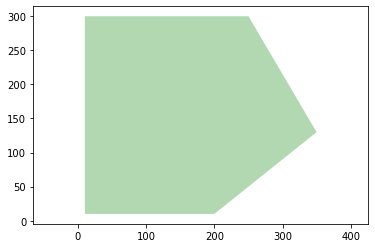

In [10]:
LAND = poly5
draw_polygon(LAND, color=COLORS_LEGEND_MAP["Land"])
printmd(f"### L'aire du terrain est de **{abs(SympyPolygon(*LAND).area)}** m²\n\n")

In [11]:
from ipynb.fs.full.PSO import fit as PSO_fit

In [12]:
LOGS = {}
DIM = 5

ACCEPT_WHEN_INVALID_MOVE = False
NB_PARTICLES = 100
NB_CYCLES = 1000
PSI, CMAX = 0.4, 1.47

LOG_PADDING = 50
INF, SUP = get_border_search_field(LAND)

if ACCEPT_WHEN_INVALID_MOVE:
    eval_function = lambda x: (
        rect := Rectangle(*x),
        rect.area() if rect.is_valid(LAND) else -rect.area())[-1]
    bounding_function = lambda x: x
else:
    eval_function = lambda x: Rectangle(*x).area()
    bounding_function = lambda x: polygon_bounding(x, LAND)
    
log_function = lambda x, it=0, fitness=None, legend=None, text=None, padding=LOG_PADDING, colors=["green", "red"]: (
    log_polygons(LAND, x, colors, legend, text, padding, it, fitness, show=False))

init_function = lambda: pick_random_sol(LAND, NB_PARTICLES, inf=INF, sup=SUP)
isbetter_function = lambda f1, f2: f1 > f2

In [13]:
best_sol = PSO_fit(eval_function=eval_function, 
    bounding_function=bounding_function, 
    log_function=log_function,
    init_function=init_function,
    isbetter_function=isbetter_function,
    nb_particle=NB_PARTICLES, 
    dim=DIM, 
    nb_cycles=NB_CYCLES,
    psi=PSI,
    cmax=CMAX)

100%|██████████| 1000/1000 [00:04<00:00, 219.52it/s]


In [14]:
# create_animation("Swarm", LAND)

In [15]:
# create_animation("Best", LAND)

In [16]:
printmd("### Solution")
print([int(x) for x in best_sol['bestpos']], "Fitness =", best_sol['bestfit'])

printmd("### Sommets du rectangle solution")
best_sol_rect = Rectangle(*best_sol['bestpos']).to_rect()
print([(int(x), int(y)) for (x,y) in best_sol_rect])

### Solution

[10, 300, 10, 45, 235] Fitness = 60178.51535760884


### Sommets du rectangle solution

[(10, 300), (10, 45), (245, 46), (245, 300)]


In [17]:
from ipynb.fs.full.DE import DE

In [18]:
optimizer = DE(eval_function, 
               bounding_func=bounding_function,
               init_func=init_function,
               dim=DIM,
               inf=INF,
               sup=SUP,
               n_agents=NB_PARTICLES,
               n_cycles=NB_CYCLES,
               isbetter_func=isbetter_function,
               log_func=log_function)

In [19]:
optimizer.fit()

100%|██████████| 1000/1000 [00:02<00:00, 385.45it/s]


60490.99926962588
60490.99926962588
60490.99926962588


True

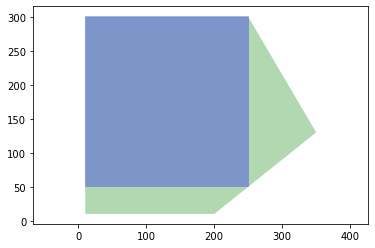

In [20]:
ag = optimizer.best_agent
sol = Rectangle(*ag['pos'])
print(ag['fit'])
print(sol.area())
print(optimizer.eval_func(ag['pos']))
draw_polygons([LAND, sol.to_rect()], colors=["green", "blue"])
sol.is_valid(LAND)

In [23]:
create_animation("DE - Best", LAND)